## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.decomposition import PCA
from datetime import timedelta
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## Load dataset

In [2]:
incident_data = pd.read_csv("data/incidents.csv")
incident_data.head(20)

,_id,type,properties_id,properties_iconCategory,properties_magnitudeOfDelay,properties_startTime,properties_endTime,properties_from,properties_to,properties_length,properties_delay,properties_aci,geometry_type
0,60854a2aadbe3a63a8cea480,Feature,b02cb3b91efabe2e3d945b35bb3ac9d9,8,4,2020-03-30T14:29:30Z,NaN,Rua Dom Pedro IV (N117),Rua Elias Garcia (N117),341.178000,0,NaN,LineString
1,60854a2badbe3a63a8cea481,Feature,79b7ffce40e6ac525dd5295547e134c3,8,4,2021-04-22T21:07:30Z,NaN,Alameda Hermano Patrone (N117) / Rua Major Afo...,Rua Doutor António Granjo,120.725078,0,NaN,LineString
2,60854a2badbe3a63a8cea482,Feature,dc03a766e0a03ab58636d17c0275e991,6,3,2021-04-25T10:34:30Z,2021-04-25T11:13:00Z,Avenida Adolfo Casais Monteiro,Praça José Escada,107.080680,68,NaN,LineString
3,60854a2badbe3a63a8cea483,Feature,3ffd6a8f0922eb647fec3e782b6cbef7,6,2,2021-04-25T10:48:00Z,2021-04-25T11:14:00Z,Brandoa,Rua Luís Pinto Coelho,235.898481,184,NaN,LineString
4,60854a2badbe3a63a8cea484,Feature,6da03a2343c1ea1f6df542dce0464705,6,3,2021-04-25T09:42:30Z,2021-04-25T11:13:00Z,Rua da Quinta do Pinheiro,Rua da Quinta do Paizinho,310.632538,138,NaN,LineString
5,60854a2badbe3a63a8cea485,Feature,5ac8335a95b104be4bd2765a00cbc3fb,6,2,2021-04-25T09:10:00Z,2021-04-25T11:13:00Z,Rua da Quinta do Paizinho,N117,385.583589,67,NaN,LineString
6,60854a2badbe3a63a8cea486,Feature,3472a310822428ecf9e108a4f2020f20,6,3,2021-04-25T08:51:30Z,2021-04-25T11:14:00Z,exit [5],N117,566.984458,228,NaN,LineString
7,60854a2badbe3a63a8cea487,Feature,177f79c5945aa14bfaf3c514442e107f,6,2,2021-04-25T06:51:30Z,2021-04-25T11:13:00Z,Estrada Dos Salgados (Estrada Da Brandoa),Avenida Ruy Luís Gomes (Estrada Da Brandoa),512.498297,107,NaN,LineString
8,60854a2badbe3a63a8cea488,Feature,a5c3f205e271d2b3abd57cd872376756,8,4,2021-04-25T07:00:00Z,2021-04-25T19:00:00Z,Ajuda,Calçada do Galvão,113.214008,0,NaN,LineString
9,60854a2cadbe3a63a8cea489,Feature,f44d8ff31eb82184d8ee8ca2f6d2cd8b,8,4,2021-04-25T07:00:00Z,2021-04-25T19:00:00Z,Calçada do Galvão,Ajuda,113.214008,0,NaN,LineString


## Eliminate useless columns and null values

In [3]:
incident_data.drop(incident_data.columns[[0,1,2,4,6,11,12]], axis=1, inplace=True) # Eliminar colunas desnecessárias
incident_data = incident_data.dropna() # Para ter a certeza que não há valores nulos

## Create training and test data

In [4]:
# Cria dados de treino e teste recorrendo à aleatoriedade
def new_train_test_sets():
    
    msk = np.random.rand(len(incident_data)) < 0.8

    train_data = incident_data[msk] # 80% dos dados
    test_data = incident_data[~msk] # 20% dos dados
    
    return (train_data,test_data)

## Turning non-numerical values into numerical

In [5]:
# Classe que codifica dataset de colunas múltiplas
class MultiColumnLabelEncoder:

    def __init__(self, columns=None):
        self.columns = columns 


    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self


    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output


    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)


    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output


# Codifica os datasets de treino e teste
def encodeData(train_data,test_data):
    
    multi = MultiColumnLabelEncoder(columns=['properties_iconCategory','properties_startTime','properties_from','properties_to'])
    new_train_data = multi.fit_transform(train_data)
    new_test_data = multi.fit_transform(test_data)   
    
    return (new_train_data,new_test_data)


### Normalizing data

In [6]:
# Normaliza os datasets de treino e teste
def normalizeData(train_data,test_data):

    scaler = MinMaxScaler(feature_range=(0, 1))

    for i in ['properties_iconCategory','properties_startTime','properties_from','properties_to','properties_length','properties_delay']:
    
        train_data[[i]] = scaler.fit_transform(train_data[[i]])
        test_data[[i]] = scaler.fit_transform(test_data[[i]])

### KNN Regression model

In [7]:
# Produz um gráfico tendo em conta o resultado da função knn_regressor(dataset)
def print_series_prediction(y_test,predic,title,label1,label2):
    plt.plot(y_test,color='blue', label='actual')
    plt.plot(predic,color='red', label='prediction')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.show()

# Aplica o KNN Regressor para obter previsões.
def knn_regressor(datasets):
    
    (X_train,y_train,X_test,y_test,title,label1,label2) = datasets
    
    model = KNeighborsRegressor(n_neighbors=3).fit(X_train,y_train)
    predictions = model.predict(X_test)
    df = pd.DataFrame({'actual':y_test,'predicted':predictions})
    print(df)
    print("Explained Variance Score:")
    print(explained_variance_score(df['actual'], df['predicted']))
    print("-------")
    print("Median Absolute Error:")
    print(median_absolute_error(df['actual'], df['predicted']))
    print("-------")
    print_series_prediction(df['actual'],df['predicted'],title,label1,label2)
    
    return df

### Datasets for prediction

In [8]:
# Prevê o delay causado por um incidente tendo em conta o tamanho do incidente em metros.
def data_length_delay():

    (temp_train_data,temp_test_data) = new_train_test_sets()
    (train_data,test_data) = encodeData(temp_train_data,temp_test_data)
    
    normalizeData(train_data,test_data)
    
    X_train = train_data.drop(['properties_startTime','properties_from','properties_to','properties_delay'],axis=1).values
    y_train = train_data['properties_delay'].values
    
    X_test = test_data.drop(['properties_startTime','properties_from','properties_to','properties_delay'],axis=1).values
    y_test = test_data['properties_delay'].values
    
    title = "Atraso para tamanho do incidente"        
    
    return (X_train,y_train,X_test,y_test,title,'Atraso','Tamanho')

In [9]:
# Prevê o número de incidentes tendo em conta uma data.
def data_startTime():
    
    (temp_train_data,temp_test_data) = new_train_test_sets()
    (train_data,test_data) = encodeData(temp_train_data,temp_test_data)
    
    normalizeData(train_data,test_data)
    
    c1 = train_data.value_counts('properties_startTime')

    rows = []

    for index, value in c1.items():
    
         rows.append([index, value])

    df = pd.DataFrame(rows, columns=["properties_startTime", "num_incidents"])
    X_train = df.drop(['num_incidents'],axis=1).values
    y_train = df['num_incidents'].values

    c2 = test_data.value_counts('properties_startTime')

    rows2 = []

    for index, value in c2.items():
    
         rows2.append([index, value])

    tmp_time = pd.DataFrame(rows, columns=["properties_startTime", "num_incidents"])
    X_test = tmp_time.drop(['num_incidents'],axis=1).values
    y_test = tmp_time['num_incidents'].values
    
    title = "Número de incidentes para datas"
    
    return (X_train,y_train,X_test,y_test,title,'Data','Número de incidentes')

In [10]:
# Prevê o número de incidentes tendo em conta a localização origem do tráfego.
def data_from():
    
    (temp_train_data,temp_test_data) = new_train_test_sets()
    (train_data,test_data) = encodeData(temp_train_data,temp_test_data)
    
    normalizeData(train_data,test_data)
    
    c1 = train_data.value_counts('properties_from')

    rows = []

    for index, value in c1.items():
    
         rows.append([index, value])

    df = pd.DataFrame(rows, columns=["properties_from", "num_incidents"])
    X_train = df.drop(['num_incidents'],axis=1).values
    y_train = df['num_incidents'].values

    c2 = test_data.value_counts('properties_from')

    rows2 = []

    for index, value in c2.items():
    
         rows2.append([index, value])

    tmp_time = pd.DataFrame(rows, columns=["properties_from", "num_incidents"])
    X_test = tmp_time.drop(['num_incidents'],axis=1).values
    y_test = tmp_time['num_incidents'].values
    
    title = "Número de incidentes para uma origem"
    

    return (X_train,y_train,X_test,y_test,title,'Origem','Número de incidentes')

In [11]:
# Prevê o número de incidentes tendo em conta a localização destino do tráfego.
def data_to():
    
    (temp_train_data,temp_test_data) = new_train_test_sets()
    (train_data,test_data) = encodeData(temp_train_data,temp_test_data)
    
    normalizeData(train_data,test_data)
    
    c1 = train_data.value_counts('properties_to')

    rows = []

    for index, value in c1.items():
    
         rows.append([index, value])

    df = pd.DataFrame(rows, columns=["properties_to", "num_incidents"])
    X_train = df.drop(['num_incidents'],axis=1).values
    y_train = df['num_incidents'].values

    c2 = test_data.value_counts('properties_to')

    rows2 = []

    for index, value in c2.items():
    
         rows2.append([index, value])

    tmp_time = pd.DataFrame(rows, columns=["properties_to", "num_incidents"])
    X_test = tmp_time.drop(['num_incidents'],axis=1).values
    y_test = tmp_time['num_incidents'].values
    
    title = "Número de incidentes para um destino"
    
    return (X_train,y_train,X_test,y_test,title,'Destino','Número de incidentes')

In [12]:
# Prevê o número de incidentes numa hora de um dia específico.
def searchData(spec_date):
    (train_data,test_data) = new_train_test_sets()
    
    rows = []
    # Formatar
    for i in range(len(train_data)):
        s = train_data.iloc[i, 1]
        date = s.split('T')[0]
        hour = (s.split('T')[1]).split(':')[0]
        res = date + " " + hour
        rows.append([res])
        
    tmp_time1 = pd.DataFrame(rows, columns=["Date"])
    serie = tmp_time1.value_counts("Date")
    
    rows2 = []
    
    # Construir dataframe e contar incidentes
    for index, value in serie.items():
    
         rows2.append([index, value])
    
    tmp_time2 = pd.DataFrame(rows2, columns=["Date","num_incidents"])
    
    # Construir dataframe com dia escolhido
    
    rows4 = []
    
    for i in range(len(tmp_time2)):
        
        s1 = tmp_time2.iloc[i, 0]
        s2 = tmp_time2.iloc[i, 1]
        if spec_date == s1.split(' ')[0]:
            
            rows4.append([s1,s2])
    
    rows5 = []
       
    # Formatar
    for i in range(len(test_data)):
        s = test_data.iloc[i, 1]
        date = s.split('T')[0]
        hour = (s.split('T')[1]).split(':')[0]
        res = date + " " + hour
        rows5.append([res])
        
    tmp_time3 = pd.DataFrame(rows5, columns=["Date"])
    serie1 = tmp_time1.value_counts("Date")
    
    rows6 = []
    
    # Construir dataframe e contar incidentes
    for index, value in serie1.items():
    
         rows6.append([index, value])
    
    tmp_time4 = pd.DataFrame(rows6, columns=["Date","num_incidents"])
    
    # Construir dataframe com dia escolhido

    rows8 = []
    
    for i in range(len(tmp_time4)):
        
        s1 = tmp_time4.iloc[i, 0]
        s2 = tmp_time4.iloc[i, 1]
        if spec_date == s1.split(' ')[0]:
            
            rows8.append([s1,s2])
    
    res = pd.DataFrame(rows4, columns=["Date", "num_incidents_hour"])
    
    res1 = pd.DataFrame(rows8, columns=["Date", "num_incidents_hour"])
    
    multi = MultiColumnLabelEncoder(columns=['Date','num_incidents_hour'])
    
    res2 = multi.fit_transform(res)
    res3 = multi.fit_transform(res1)
        
    X_train = res2.drop(['num_incidents_hour'],axis=1).values
    y_train = res2['num_incidents_hour'].values
    
    X_test = res3.drop(['num_incidents_hour'],axis=1).values
    y_test = res3['num_incidents_hour'].values
    
    title = "Número de incidentes numa data específica"
    
    return (X_train,y_train,X_test,y_test,title,'Hora','Número de incidentes')


def last_24(data):
    
    rows = []
    
    for i in range(len(data)):
        s = data.iloc[i, 1]
        date = s.split('T')[0]
        hour = (s.split('T')[1]).split(':')[0]
        res = date + " " + hour
        rows.append([res])
        
    tmp_time = pd.DataFrame(rows, columns=["Date"])
    
    rows1 = []
    rows2 = []
    max = None
    for i in range(len(tmp_time)):
         
        s = tmp_time.iloc[i, 0]
        date_object = datetime.datetime.strptime(s, '%Y-%m-%d %H')
        rows1.append(date_object)
        rows1.sort()
        rows2.append([rows1[i]])
        
        
    max = (rows2[-1])[0] - timedelta(1)
    c = (rows2[-1])[0]
    
    rows3 = []
    i = 0
    while i + 15942 < len(rows2):
        
        s = (rows2[15942+i])[0].strftime('%Y-%m-%d %H')
        rows3.append([s])
        i = i + 1
    
    tmp_time1 = pd.DataFrame(rows3, columns=["Date"])
    serie = tmp_time1.value_counts("Date")
    
    rows4 = []
    
    for index, value in serie.items():
    
         rows4.append([index, value])
    
    tmp_time2 = pd.DataFrame(rows4, columns=["Date","num_incidents_hour"])
    
    msk = np.random.rand(len(tmp_time2)) < 0.8

    train_data = tmp_time2[msk]
    test_data = tmp_time2[~msk] 
    
    multi = MultiColumnLabelEncoder(columns=['Date','num_incidents_hour'])
    
    resTrain = multi.fit_transform(train_data)
    resTest = multi.fit_transform(test_data)
        
    X_train =  resTrain.drop(['num_incidents_hour'],axis=1).values
    y_train =  resTrain['num_incidents_hour'].values
    

    X_test = resTest.drop(['num_incidents_hour'],axis=1).values
    y_test = resTest['num_incidents_hour'].values
    
    title = "Número de incidentes nas últimas 24 horas"
    
    return(X_train,y_train,X_test,y_test,title,'Hora','Número de incidentes')


## Resultados

In [13]:
d1 = data_length_delay()
d2 = data_startTime()

d5 = searchData('2021-04-26')
d6 = last_24(incident_data)

In [14]:
d3 = data_from()
d4 = data_to()

        actual  predicted
0     0.000000   0.000000
1     0.000000   0.000000
2     0.000000   0.000000
3     0.187778   0.062323
4     0.220000   0.050587
...        ...        ...
3587  0.202222   0.061783
3588  0.036667   0.020774
3589  0.191111   0.067314
3590  0.038889   0.021044
3591  0.095556   0.077162

[3592 rows x 2 columns]
Explained Variance Score:
0.039652527696767303
-------
Median Absolute Error:
0.085403345474167
-------


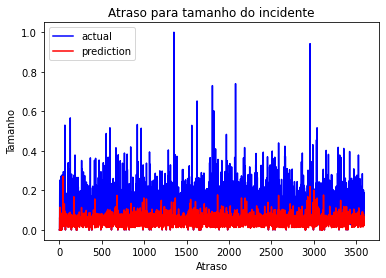

In [15]:
knn1 = knn_regressor(d1)

      actual  predicted
0         93  49.000000
1         52  54.333333
2         49  36.000000
3         45  31.666667
4         30  18.333333
...      ...        ...
7990       1   1.666667
7991       1   1.000000
7992       1   2.000000
7993       1   1.000000
7994       1   1.000000

[7995 rows x 2 columns]
Explained Variance Score:
0.5914255458930691
-------
Median Absolute Error:
0.33333333333333326
-------


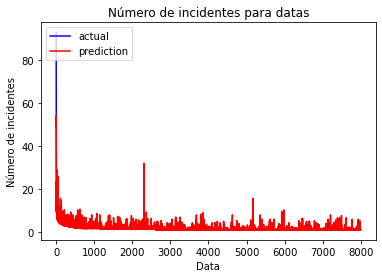

In [16]:
knn2 = knn_regressor(d2)

      actual  predicted
0        207  80.333333
1        201  83.000000
2        145  51.666667
3        143  63.000000
4        119  51.000000
...      ...        ...
2852       1   1.000000
2853       1   1.666667
2854       1   1.666667
2855       1   1.666667
2856       1   3.000000

[2857 rows x 2 columns]
Explained Variance Score:
0.4103105766780767
-------
Median Absolute Error:
1.3333333333333335
-------


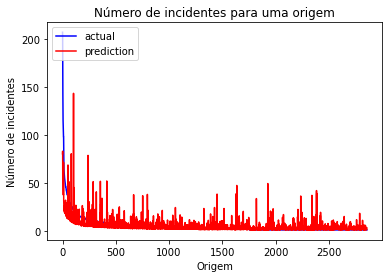

In [17]:
knn3 = knn_regressor(d3)

      actual   predicted
0        241  117.000000
1        172   61.333333
2        135  121.666667
3        133   51.333333
4        127   88.666667
...      ...         ...
2484       1    1.666667
2485       1    2.666667
2486       1    2.000000
2487       1    6.666667
2488       1    1.333333

[2489 rows x 2 columns]
Explained Variance Score:
0.5284445809411278
-------
Median Absolute Error:
1.6666666666666665
-------


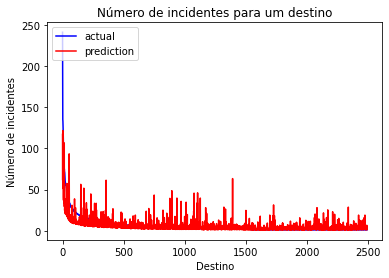

In [18]:
knn4 = knn_regressor(d4)

    actual  predicted
0       20  16.000000
1       19  16.666667
2       18  18.000000
3       17  16.333333
4       16  16.333333
5       15  12.000000
6       14  13.666667
7       13  11.666667
8       13  13.666667
9       12  11.666667
10      11  11.333333
11      10  11.333333
12      10  14.000000
13       9   7.333333
14       8   7.333333
15       7   6.333333
16       6   6.666667
17       5   8.666667
18       4   4.666667
19       3   4.666667
20       2   1.000000
21       1   1.000000
22       0   3.000000
Explained Variance Score:
0.8945474400019855
-------
Median Absolute Error:
0.6666666666666679
-------


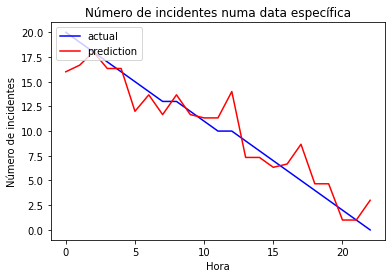

In [19]:
knn5 = knn_regressor(d5)

   actual  predicted
0       8   2.000000
1       7   3.000000
2       6   0.333333
3       5   0.666667
4       4   1.666667
5       3  10.666667
6       2  10.666667
7       1   4.666667
8       0   7.333333
Explained Variance Score:
-4.111111111111112
-------
Median Absolute Error:
5.666666666666667
-------


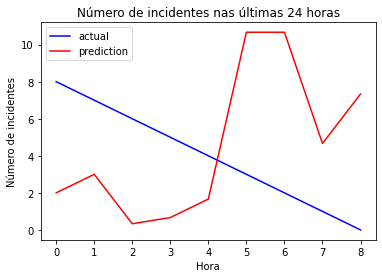

In [20]:
knn6 = knn_regressor(d6)

In [21]:
knn1.to_csv('data/delay_tam_pred.csv')
knn2.to_csv('data/num_inc_data_pred.csv')
knn3.to_csv('data/num_inc_ori_pred.csv')
knn4.to_csv('data/num_inc_dest_pred.csv')
knn5.to_csv('data/num_inc_spec_data.csv')
knn6.to_csv('data/num_inc_24_pred.csv')